<a href="https://colab.research.google.com/github/Cheokerinos/SC3000/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Importing dependencies and define helper functions

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
#import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [4]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [9]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [12]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02794954 -0.04309896  0.00799442 -0.02745308]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [13]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02881152 -0.23833464  0.00744536  0.2677414 ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [14]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [24]:
alpha = 0.5
gamma = 0.95
episodes = 100000
max_reward = 500
prior_reward = 0
min_epsilon = 0.05
total_reward = 0

Observation = [30, 30, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

epsilon = 1
epsilon_decay_value = 0.99995
num_actions = env.action_space.n

q_table = np.random.uniform(low=0, high=1, size=(Observation + [num_actions]))
q_table.shape

def discrete_state(state): #Give the states discrete values instead of a continuous range of state values
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    return tuple(discrete_state.astype(int))

def RL_policy_agent(observation):
    state = discrete_state(observation)
    if np.random.random() <epsilon:
      action = np.random.randint(0, env.action_space.n)
    else:
      action = np.argmax(q_table[state])
    return action

def q_learning(state,action,reward,next_state,done):
  current_state = discrete_state(state)
  next_state = discrete_state(next_state)
  max_future_q = np.max(q_table[next_state])
  current_q = q_table[current_state + (action,)]
  q_table[current_state + (action,)] = (1 - alpha) * current_q + alpha * (reward + gamma * max_future_q)

for episode in range(episodes+1):
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done and cumulative_reward < max_reward:
    action = RL_policy_agent(observation)
    next_observation, reward, done, _ = env.step(action)

    cumulative_reward += reward
    q_learning(observation, action, reward, next_observation, done)
    observation = next_observation

  if epsilon>min_epsilon:
    if cumulative_reward > prior_reward and episode > 10000:
      epsilon = math.pow(epsilon_decay_value, episode - 10000)


  total_reward += cumulative_reward
  prior_reward = cumulative_reward

  if(episode%1000 == 0):
    mean_reward = total_reward/1000
    print("episode: ", episode, "Mean Reward: ", str(mean_reward))
    total_reward = 0



episode:  0 Mean Reward:  0.012
episode:  1000 Mean Reward:  22.344
episode:  2000 Mean Reward:  22.311
episode:  3000 Mean Reward:  22.342
episode:  4000 Mean Reward:  22.532
episode:  5000 Mean Reward:  23.059
episode:  6000 Mean Reward:  22.394
episode:  7000 Mean Reward:  22.5
episode:  8000 Mean Reward:  21.928
episode:  9000 Mean Reward:  22.553
episode:  10000 Mean Reward:  22.48
episode:  11000 Mean Reward:  22.12
episode:  12000 Mean Reward:  24.804
episode:  13000 Mean Reward:  27.309
episode:  14000 Mean Reward:  29.765
episode:  15000 Mean Reward:  31.704
episode:  16000 Mean Reward:  34.523
episode:  17000 Mean Reward:  38.068
episode:  18000 Mean Reward:  42.107
episode:  19000 Mean Reward:  44.487
episode:  20000 Mean Reward:  49.1
episode:  21000 Mean Reward:  52.693
episode:  22000 Mean Reward:  55.743
episode:  23000 Mean Reward:  61.548
episode:  24000 Mean Reward:  67.01
episode:  25000 Mean Reward:  72.641
episode:  26000 Mean Reward:  76.396
episode:  27000 Mean R

I trained the algorithm using 100000 episodes, to ensure that I give the RL Agent enough episodes to achieve a satisfiable consistent Mean Reward. As shown above.
#Analysis
We can see that the agent only starts learning after 10000 episodes.
After ~42000 episodes, the agent achieves a mean reward of **150**.
After ~50000 episodes, the agent achieves a mean reward of **220**.
After ~58000 episodes, the agent achieves a mean reward of **300**
After ~71000 episodes, the agent achieves a mean reward of **400**
The agent continues to only learn and improve its mean rewards to ~**450** by episode 100000.
#Alpha
I set alpha at 0.5 as it is the greatest balance between stability and learning. If I set it too high it can result in an unstable Q-table while setting too low will result in the agent not learning fast enough. Hence 0.5 is the sweet spot.
#Epsilon
I set Epsilon to begin 1 to encourage exploration for the Agent and I only started to decay the epsilon after 10000 episodes. At first, I set the epsilon to start decaying after 5000 episodes. However, I realised the Agent still continues to not learn or achieve a higher mean reward despite allowing it to exploit its Q-table earlier. Hence, I settled with 10000 to allow the agent to explore and familiarise itself with the environment first before decaying and using the Q-table to choose the best action. This would allow the Agent to better make decisions and choosing the best max Q-value.
#Epsilon Decay
The epsilon decay value is set at 0.99995 as well to encourage more exploring after the first 10000 episodes, this is to prevent the Agent from stabilising the Q-table too quickly due to lack of eploration. Furthermore, I use a random float generator np.random.random() to decide between Exploration or Exploitation. This allows for a great, unbiased selection of exploration or exploitation of action by the Agent. Hence, I am able to achieve a good balance between exploitation and exploration.

For Task 1, we can show the observation and chosen action below:

In [25]:
observation = env.reset()
action = RL_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.01810119 -0.02876062 -0.03747612 -0.03144415]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

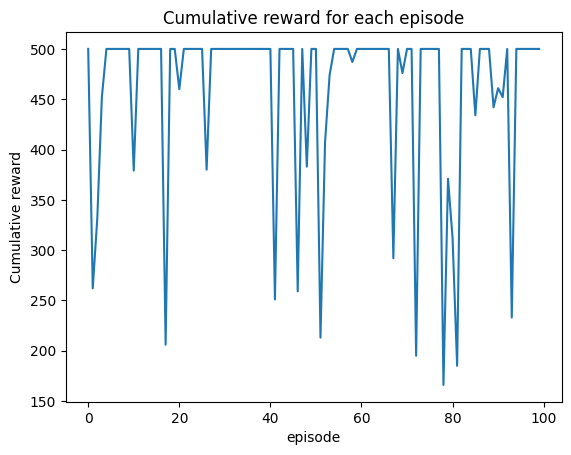

Average Reward:  459.64


In [32]:
num_episodes = 100
episode_results = []
max_reward = 500

for episode in range(num_episodes):
  observation = env.reset()
  cumulative_reward = 0
  done = False
  while not done and cumulative_reward < max_reward:
    action = RL_policy_agent(observation)
    next_observation, reward, done, _ = env.step(action)

    cumulative_reward += reward
    q_learning(observation, action, reward, next_observation, done)
    observation = next_observation

  if epsilon>min_epsilon:
    if cumulative_reward > prior_reward and episode > 10000:
      epsilon = math.pow(epsilon_decay_value, episode - 10000)


  total_reward += cumulative_reward
  prior_reward = cumulative_reward
  episode_results.append(cumulative_reward)

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()
print("Average Reward: ", np.mean(episode_results))

Hence, we can see that the agent has learned enough about the CartPole environment and the lowest episodic reward is lower than 100 and the highest reaches 500. The Average reward is 317.21 which is relatively good with an Agent that has only trained with 60000 episodes.

In [33]:
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Average cumulative reward: 459.64
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [60]:
env = gym.make("CartPole-v1")
env = RecordVideo(env, "./video")
observation, reward, done, info = env.reset()
total_reward = 0
while True:
    env.render()
    #your agent goes here
    action = RL_policy_agent(observation)
    results = env.step(action)
    observation, reward,done= results[:3]
    total_reward += 1
    if done:
      break
print("Reward: ", total_reward)
env.close()
show_video()

Reward:  500
